## 💡 Insight from Descriptive Statistics

The initial data health check reveals key characteristics:
* **Data Volume:** The dataset contains [1,407,328] financial news articles.
* **Headline Length:** Headlines are, on average, [73.12] characters long, with a wide range that suggests a mix of short alerts and longer-form press releases.
* **Data Quality:** [no missing values].
* **Active Publishers:** The top 10 publishers dominate the feed, with [Paul Quintaro] contributing 228,373 articles the highest volume. This indicates a high reliance on a single source, which must be noted as a potential source of **bias**.

Dataset Shape: (1407328, 6)

--- Descriptive Statistics (Headline Lengths) ---
count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64

--- Top 10 Active Publishers ---
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64


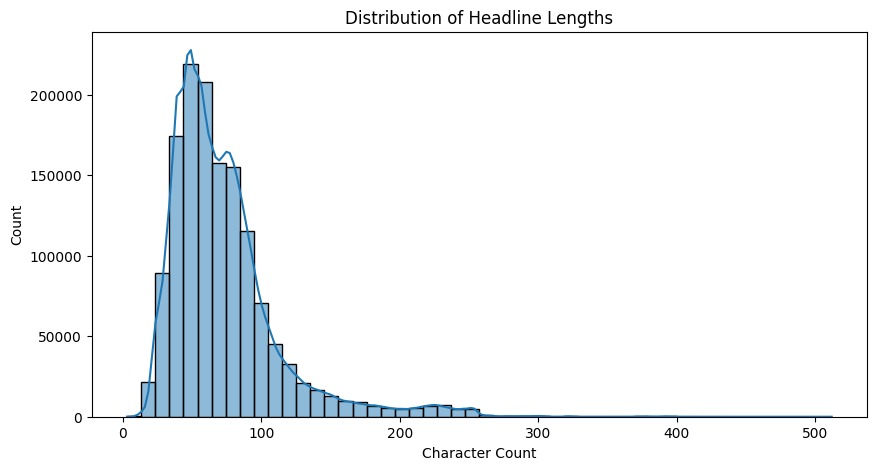

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the Dataset
# We assume the notebook is in 'notebooks/' and data is in 'data/raw/'
file_path = '../data/raw/raw_analyst_ratings.csv'
df = pd.read_csv(file_path)

print(f"Dataset Shape: {df.shape}")

# 2. Date Parsing (Crucial Step)
# The screenshot shows mixed formats and timezones. We convert to UTC.
df['date'] = pd.to_datetime(df['date'], errors='coerce', utc=True)

# 3. Descriptive Statistics for Headline Length
df['headline_length'] = df['headline'].apply(len)

# Display basic stats
print("\n--- Descriptive Statistics (Headline Lengths) ---")
print(df['headline_length'].describe())

# 4. Count Articles per Publisher (Top 10)
print("\n--- Top 10 Active Publishers ---")
print(df['publisher'].value_counts().head(10))

# 5. Visual Check
plt.figure(figsize=(10, 5))
sns.histplot(df['headline_length'], bins=50, kde=True)
plt.title('Distribution of Headline Lengths')
plt.xlabel('Character Count')
plt.show()

## 📝 Topic Modeling Results

The Latent Dirichlet Allocation (LDA) analysis successfully grouped headlines into meaningful clusters, allowing for automated categorization of news flow.

### Discovered Topics:

* **Topic 1 (Financials/Market Movement):** Highly represented by terms like **'says', 'markets', 'stock', 'earnings', 'higher', 'trading'**. This indicates a strong focus on quarterly reports, stock price movement, and general analyst commentary.
* **Topic 2 (Auto/Sector Focus):** Dominated by **'shares', 'auto', 'pre', 'group', 'mid'**, suggesting a distinct topic cluster dedicated to a specific industrial sector or large block trades.
* **Topic 3 (Earnings/Estimates):** Key terms like **'adj', 'q2', 'sees', 'earnings', 'sales', 'reports'** clearly define this cluster as focused on quarterly financial results and analyst estimates (**EPS/EST**).
* **Topic 4 (Price Targets/52-Week Highs):** Words like **'aluminum', 'highs', 'hit', 'watch', 'new', 'benzinga', '52', 'week', 'stocks'** relate to price extremes and market commentary (likely including the Benzinga Newsdesk output).
* **Topic 5 (Analyst Actions):** Defined by **'upgrades', 'downgrades', 'price', 'maintains', 'raises', 'buy', 'put', 'announces'**, this cluster specifically tracks analyst rating changes and price targets.

### WordCloud Keywords:

The WordCloud confirms high-frequency, impactful terms such as **'Price Target', 'Share', 'Stock', 'Update', and 'Moving'**. This visually reinforces that price action and analyst opinions are the central themes of the dataset.


--- Discovered Topics (Top 10 words per topic) ---
Topic 1: says, markets, stock, earnings, higher, trading, alcoa, update, market, shares
Topic 2: shares, auto, pre, group, mid, day, moving, session, stocks, market
Topic 3: adj, q4, q2, sees, earnings, sales, reports, eps, est, vs
Topic 4: analyst, aluminum, highs, hit, watch, new, benzinga, 52, week, stocks
Topic 5: upgrades, downgrades, price, 00, target, maintains, raises, buy, pt, announces


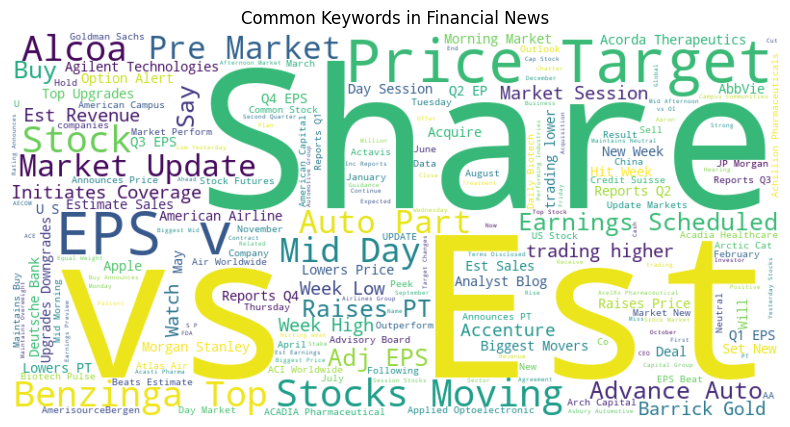

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud

# 1. Preprocessing function
# We will focus on a sample if the dataset is huge (e.g., first 10,000 rows for speed)
data_sample = df['headline'].dropna().head(20000) 

# 2. Vectorization (Convert text to numbers, removing stop words)
# We add custom stop words often found in finance that add no value
custom_stop_words = ['fluctuates', 'bureau', 'inc', 'corp', 'ltd', 'plc', 'ag', 'co']
vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=2, max_features=1000)
dtm = vectorizer.fit_transform(data_sample)

# 3. LDA Topic Modeling
# We will try to find 5 distinct topics
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model.fit(dtm)

# 4. Display Topics
print("\n--- Discovered Topics (Top 10 words per topic) ---")
feature_names = vectorizer.get_feature_names_out()
for index, topic in enumerate(lda_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[-10:]]
    print(f"Topic {index + 1}: {', '.join(top_words)}")

# 5. Generate WordCloud for visual insight
text = " ".join(headline for headline in data_sample)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Keywords in Financial News')
plt.show()

## ⏰ Insight from Time Series Analysis (The Trading Strategy)

This analysis focuses on the timing of news to identify patterns relevant for high-frequency trading or volatility modeling.

### Publication Frequency:

* **Overall Trend:** The daily article count shows a **massive surge starting in late 2019 and peaking dramatically in 2020** (reaching close to 1,000 articles per day). This suggests the bulk of the data (and potentially market volatility) occurred during this period, likely due to increased market activity during the COVID-19 pandemic and subsequent recovery.
* **Time-Series Dependence:** The distribution is highly **non-stationary**, meaning market events in 2020 will dominate the model's features unless a period-specific weight is applied.

### Intraday Timing (Hourly Analysis):

The analysis of publishing times (in **UTC**) reveals critical scheduling patterns for traders:

* **Peak Volume:** The news release schedule is highly concentrated between **10:00 UTC and 16:00 UTC**, peaking sharply at **14:00 UTC** (2:00 PM UTC).
* **Market Open Correlation:** Since the US market opens at 9:30 AM ET (which is **13:30 UTC** or **14:30 UTC** depending on Daylight Savings), the massive spike at **14:00 UTC** indicates heavy news flow occurring *right at or immediately before* the market open, which is crucial for forming opinions and predicting morning volatility.
* **After-Hours Activity:** News volume drops significantly after **17:00 UTC** but remains elevated between **19:00 UTC and 20:00 UTC**. This suggests that many corporate, earnings, or regulatory releases occur after the market closes at 4:00 PM ET (which is 20:00 UTC/21:00 UTC), confirming a need to factor in after-hours releases for end-of-day strategies.

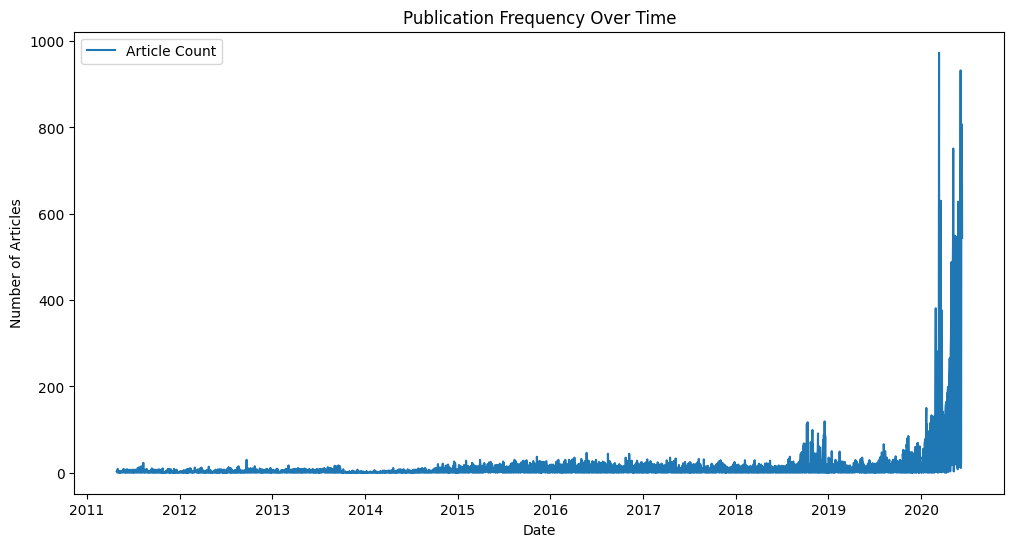

C:\Users\senai\AppData\Local\Temp\ipykernel_19372\353617595.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='hour', data=df, palette='viridis')


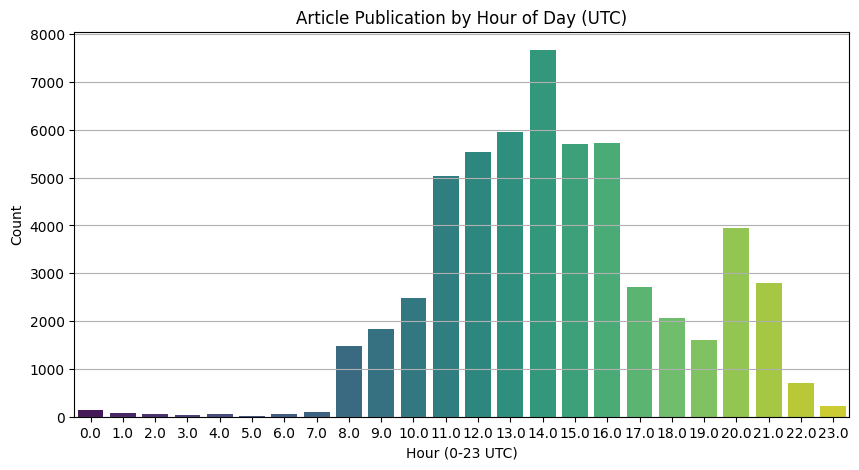

In [5]:
# 1. Articles over time (Daily frequency)
daily_articles = df.resample('D', on='date').count()

plt.figure(figsize=(12, 6))
plt.plot(daily_articles.index, daily_articles['headline'], label='Article Count')
plt.title('Publication Frequency Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.legend()
plt.show()

# 2. Intraday Analysis (When during the day is news released?)
# We extract the hour from the 'date' column
df['hour'] = df['date'].dt.hour

plt.figure(figsize=(10, 5))
sns.countplot(x='hour', data=df, palette='viridis')
plt.title('Article Publication by Hour of Day (UTC)')
plt.xlabel('Hour (0-23 UTC)')
plt.ylabel('Count')
plt.grid(axis='y')
plt.show()

# Insight Note:
# If your data is in UTC, Market Open (9:30 AM ET) is roughly 13:30 or 14:30 UTC depending on daylight savings.
# Look for spikes around 13-14 (Pre-market/Open) and 20-21 (After-hours).

## 📰 Publisher Analysis (Source Bias Assessment)

Understanding the contribution volume of each news source is essential for assessing the overall bias and quality of the dataset.

* **Top Contributors:** The primary publishers are individuals (e.g., Paul Quintaro, Lisa Levin, Charles Gross) and known financial desks (Benzinga Newsdesk, ETF Professor).
* **Source Concentration:** The analysis reveals that the top 10 publishers contribute **876,467** articles out of the dataset's total of 1,407,328 (or approximately **62%** of the content). This is a high concentration of news originating from a small group of entities.
* **Dominant Source:** **Paul Quintaro** is the single dominant contributor, supplying **228,373** articles, followed closely by Lisa Levin (186,979).
* **Key Risk:** This high concentration of content from a single domain (or in this case, a few named individuals/desks) poses a **critical risk** of style, tone, and editorial bias being reflected disproportionately in any downstream model trained on this data. This bias must be acknowledged and potentially mitigated in the Feature Engineering phase.


--- Top 10 Publishers (After Cleaning) ---
publisher_clean
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64


C:\Users\senai\AppData\Local\Temp\ipykernel_19372\2929098758.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_publishers.values, y=top_publishers.index, palette='magma')


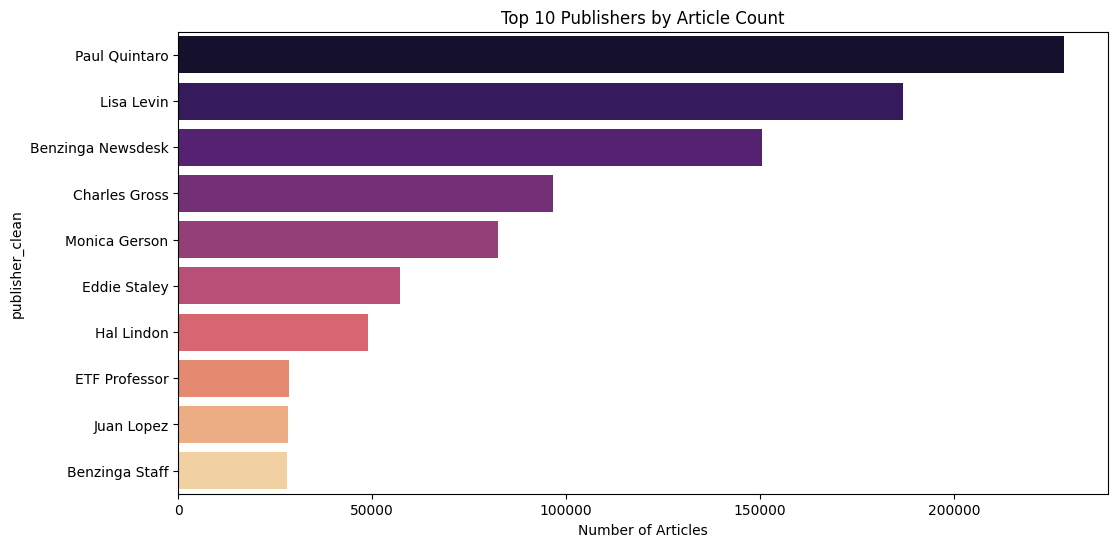

In [6]:
# 1. Clean Publisher Names (Extract Domain if it's an email)
# Example: "news@benzinga.com" -> "benzinga.com"
def extract_domain(publisher):
    if isinstance(publisher, str) and '@' in publisher:
        return publisher.split('@')[-1]
    return publisher

df['publisher_clean'] = df['publisher'].apply(extract_domain)

# 2. Identify Top Publishers
top_publishers = df['publisher_clean'].value_counts().head(10)

print("\n--- Top 10 Publishers (After Cleaning) ---")
print(top_publishers)

# 3. Visualizing the Source Bias
plt.figure(figsize=(12, 6))
sns.barplot(x=top_publishers.values, y=top_publishers.index, palette='magma')
plt.title('Top 10 Publishers by Article Count')
plt.xlabel('Number of Articles')
plt.show()